# Закономерности и тенденции в рейтингах аниме

Аниме, как жанр аудиовизуального искусства, демонстрирует значительный рост популярности в последние десятилетия. Одним из ключевых аспектов анализа является оценка качества, которая, как правило, выражается в рейтингах и отзывах зрителей.

Целью данного исследования является проведение анализа оценок аниме с целью выявления статистических закономерностей и тенденций. В частности поставим перед собой следующие задачи:
 - **Сбор данных**: Используя инструменты веб-парсинга, реализуем скрипт для получения выборки, необходимой для дальнейшего анализа.
 - **Предварительный анализ**: Получим несмещенные, состоятельные и эффективные оценки для составления исчерпывающей выборки.
 - **Анализ оценок**: Построим *доверительные интервалы* и проверим *статистические гипотезы* на исчерпывающей выборке.
 - **Тенденции во времени**: Проанализируем изменения в оценках с течением времени.
 - **Исследование категорий**: Определим, какие жанры и студии наиболее популярны и получают самые большие средние оценки.

### Импортируем необходимые библиотеки

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

from requests import get
from bs4 import BeautifulSoup

import warnings

warnings.filterwarnings('ignore')

## Модуль 1: Сбор данных

В качестве сайта для сбора будем использовать [Animego.org](https://animego.org/), так как это один из самых популярных тематических сайтов в России, содержащий в себе всю необходимую информацию по каждому произведению. Также в нем уже реализован адрес для получения случайного аниме, что упростит составление репрезентативной выборки.

Проверим возможен ли парсинг сайта со стандартными агентами.

In [10]:
link = 'https://animego.org/anime/random'
response = get(link)

response

<Response [200]>

Ошибок нет, поэтому составим парсер. Информацию будем записывать в `pandas.DataFrame` для удобного взаимодействия с данными.

In [11]:
def parse_site(n: int) -> pd.DataFrame:
    df = pd.DataFrame([])
    while df.shape[0] != n:
        link = 'https://animego.org/anime/random'
        response = get(link)
        
        soup = BeautifulSoup(response.content, 'html.parser')
    
        item = {}
        
        try: item['title'] = soup.find('div', {'class': 'anime-title'}).h1.text 
        except Exception: continue

        if pd.isnull(item['title']): continue
            
        item['genres'] = ';'.join([a.text for a in soup.find_all('a', href=True) if 'genre' in a['href']])
        
        try:
            item['rating'] = float(soup.find('span', {'class': 'rating-value'}).text.replace(',', '.'))
            item['rating_voters'] = int(soup.find('div', {'class': 'rating-count'}).text)
        except Exception:
            pass
            
        try: item['season'] = [a.text for a in soup.find_all('a', href=True) if 'season' in a['href']][0]
        except Exception: item['season'] = None   
            
        try: item['studio'] = [a.text for a in soup.find_all('a', href=True) if 'studio' in a['href']][0] 
        except Exception: item['studio'] = None 
            
        try: item['origin'] = soup.find('dd', {'class': 'col-6 col-sm-8 mb-1'}).text 
        except Exception: item['origin'] = None
            
        try: item['pg'] = soup.find('dd', {'class': 'col-6 col-sm-8 mb-1 mt-1'}).text.strip() 
        except Exception: item['pg'] = None
            
        try: item['type'] = soup.find('dd', {'class': 'col-6 col-sm-8 mb-1'}).text 
        except Exception: item['type'] = None
            
        try: item['episode_count'] = int(soup.find_all('dd', {'class': 'col-6 col-sm-8 mb-1'})[1].text) 
        except Exception: item['episode_count'] = 1  
        if df.empty:
            df = pd.DataFrame([item])
        else:
            df = pd.concat([df, pd.DataFrame([item])], axis=0)
        df = df.drop_duplicates()
    df = df.set_index(np.arange(df.shape[0]))
    return df

In [12]:
parse_site(5)

,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
0,Девушки на линии фронта,Военное;Драма;Фантастика;Экшен,6.7,705,Зима 2022,Asahi Production,ТВ Сериал,12+,ТВ Сериал,12
1,Мастера Меча Онлайн 2,Игры;Приключения;Романтика;Фэнтези;Экшен,8.6,16968,Лето 2014,A-1 Pictures Inc.,ТВ Сериал,18+,ТВ Сериал,24
2,Вольный стиль! Заплыв в будущее,Драма;Комедия;Повседневность;Спорт;Школа,8.8,1233,Лето 2018,Animation Do,ТВ Сериал,16+,ТВ Сериал,12
3,Великий притворщик,Детектив;Комедия;Приключения;Психологическое;Э...,9.0,4498,Лето 2020,Wit Studio,ТВ Сериал,18+,ТВ Сериал,23
4,"Не издевайся, Нагаторо: Вторая атака",Комедия;Повседневность;Романтика,8.3,6692,Зима 2023,Oriental Light and Magic,ТВ Сериал,16+,ТВ Сериал,12


## Модуль 2: Предварительный анализ 

Отлично, парсер готов. Далее для составления выборки стоит ответственно подойти к количеству наблюдений. Чтобы определить необходимый объем выборки для достижения требуемой надежности доверительного интервала используется формула

![формула количества наблюдений](DATA/req_data.png)

Эту формулу и возьмем за основу для нахождения необходимого числа наблюдений, однако в числителе присутствует генеральная дисперсия, которую откуда-то нужно достать. Единственный возможный способ - получить оценку. Чем больше значений, тем точнее оценка дисперсии, так как она асимптотически стремится к истинному значению. Обычно асимптотика работает корректно при объеме выборки более 100, поэтому составим выборку из 125 значений и примем ее несмещенную оценку за дисперсию генеральной совокупности.

In [13]:
df = parse_site(125)
print(f'Выборка сожержит {df.title.nunique()} уникальных значений')
df.head(5)

Выборка сожержит 125 уникальных значений


,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
0,Рок-шоу! Звёзды!,Комедия;Музыка,7.1,132.0,Зима 2021,Kinema Citrus,ТВ Сериал,16+,ТВ Сериал,12
1,Синяя тюрьма: Блю Лок,Сёнэн;Спорт,9.2,22545.0,Осень 2022,8bit,ТВ Сериал,16+,ТВ Сериал,24
2,Ван-Пис фильм 4: Путешествие в один конец,Комедия;Приключения;Сёнэн;Супер сила;Фэнтези;Э...,7.8,525.0,None,Toei Animation,Фильм,16+,Фильм,1
3,Врата Штейна: Эгоистичная пориомания,Комедия;Триллер;Фантастика,9.1,3030.0,None,White Fox,Спешл,16+,Спешл,1
4,"Клинок, рассекающий демонов: Деревня кузнецов",Исторический;Сёнэн;Фэнтези;Экшен,9.2,35679.0,Весна 2023,ufotable,ТВ Сериал,18+,ТВ Сериал,11


Теперь по ней определим несмещенную оценку дисперсии.

In [14]:
s = df.rating.var(ddof=1)
s

1.149427584338165

Подставим это значение в формулу выше и получим необходимую для дальнейшего анализа численность выборки.

In [22]:
n = (2.58 ** 2 * s) / 0.1 ** 2 # будем строить 99%-ДИ с отклонением 0.1 
n = int(np.ceil(n))
n

686

И наконец составим исчерпывающую выборку с помощью парсера.

In [23]:
df = parse_site(n)
print(f'Выборка сожержит {df.title.nunique()} уникальных значений')
df.head()

Выборка сожержит 685 уникальных значений


,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
0,Другая сторона сэйю на радио,Драма;Комедия;Школа,7.7,178.0,Весна 2024,Connect,ТВ Сериал,16+,ТВ Сериал,12
1,Истории подделок,Детектив;Комедия;Сверхъестественное;Этти,8.7,1593.0,Зима 2012,SHAFT,ТВ Сериал,18+,ТВ Сериал,11
2,Дневник будущего: Повторный набор,Психологическое;Сверхъестественное;Сёнэн;Экшен,8.1,3135.0,None,asread,OVA,18+,OVA,1
3,Рассвет Йоны,Комедия;Приключения;Романтика;Сёдзё;Фэнтези;Экшен,8.9,2891.0,Осень 2014,Studio Pierrot,ТВ Сериал,16+,ТВ Сериал,24
4,"Дальше, чем космос",Драма;Комедия;Повседневность;Приключения,8.7,459.0,Зима 2018,Madhouse Studios,ТВ Сериал,16+,ТВ Сериал,13


Построим по этой выборке оценки параметров.

In [24]:
print(f'Оценка среднего рейтинга генеральной совокупности: {df.rating.mean()}')
print(f'Оценка стандартного отклонения рейтинга генеральной совокупности: {df.rating.std(ddof=1)}')

Оценка среднего рейтинга генеральной совокупности: 7.846926536731635
Оценка стандартного отклонения рейтинга генеральной совокупности: 1.130375843978053


На будущее сохраним результат работы парсера в **csv-файл**

In [30]:
df.to_csv('anime_data.csv')

## Модуль 3: Анализ оценок

Построим **Доверительный инетрвал для среднего** генеральной совокупности и построим распределение оценок.

In [26]:
se = df.rating.std(ddof=1) / np.sqrt(df.shape[0])
lam = 2.58 * se
sample_mean = df.rating.mean()

print(f'[{sample_mean - lam};{sample_mean + lam}]')

[7.735579025035264;7.958274048428006]


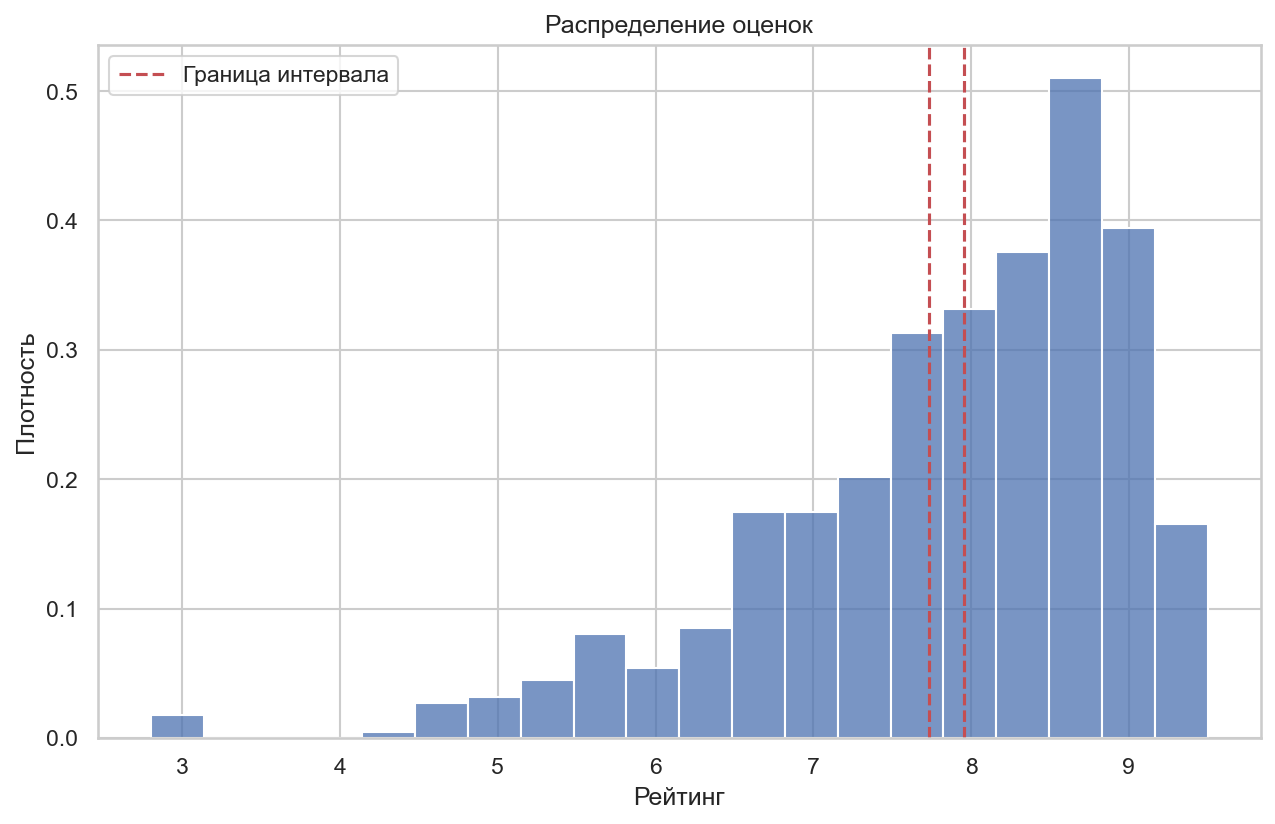

In [162]:
plt.figure(figsize=(10, 6), dpi=150)
sns.set(style="whitegrid")

sns.histplot(df.rating, fill=True, stat='density', palette='pastel')
plt.axvline(x=sample_mean - lam, ls='--', c='r', label='Граница интервала')
plt.axvline(x=sample_mean + lam, ls='--', c='r')
plt.title('Распределение оценок')
plt.xlabel('Рейтинг')
plt.ylabel('Плотность')
plt.legend(loc='upper left');

Доверительный интервал для среднего очень узкий, поэтому смело будем использовать оценку за истинное значение.

Также построим **Доверительный интервал для дисперсии** генеральной совокупности.

In [28]:
s = df.rating.std(ddof=1)
alpha = 0.05

left_border = ((n - 1) * s ** 2) / (stats.chi2(df=n-1).ppf(1 - alpha / 2))
right_border = ((n - 1) * s ** 2) / (stats.chi2(df=n-1).ppf(alpha / 2))

print(f'[{left_border};{right_border}]')

[1.152534675763856;1.4246500346222]


Сразу в глаза бросается то, что значения существенно смещены от предполагаемого центра оценивания. Убедимся в этом, проведя **статистический тест**, при помощи одновыборочного критерия Уилкоксона.
Сформулируем гипотезы:

- *H0: μ = 5*
- *H1: μ ≠ 5*

In [29]:
diff = df.rating - 5
diff = diff.dropna()
print(f'p_value = {stats.wilcoxon(diff)[1].round(5)}')

p_value = 0.0


Найдено существенное различие, **нулевая гипотеза о равенстве среднего пяти отвергается**.

Из этого можно сделать вывод, что люди склонны завышать оценки произведений, беря за среднее значение оценку 7.8, но никак не 5.

## Модуль 4: Тенденции во времени

Теперь проверим, улучшилось ли в среднем качество аниме с течением времени. Для этого отсортируем Датафрейм по сезону выпуска и построим **линию тренда** в оценках.

In [31]:
def extract_season_date(df):
    seasons = {'Зима': 1, 'Весна': 2, 'Лето': 3, 'Осень': 4}
    month, year = df.season.split()
    month = seasons[month]
    year = int(year)
    df.season = pd.to_datetime(f'{year}-{month}', format="%Y-%m")
    return df

In [32]:
season_df = df[['season', 'rating']]
season_df.dropna(inplace=True)
season_df = season_df.apply(extract_season_date, axis=1)
season_df.sort_values(by='season', inplace=True)
season_df = season_df.groupby('season').agg('mean')
season_df = season_df.reset_index().drop(columns=['season'])

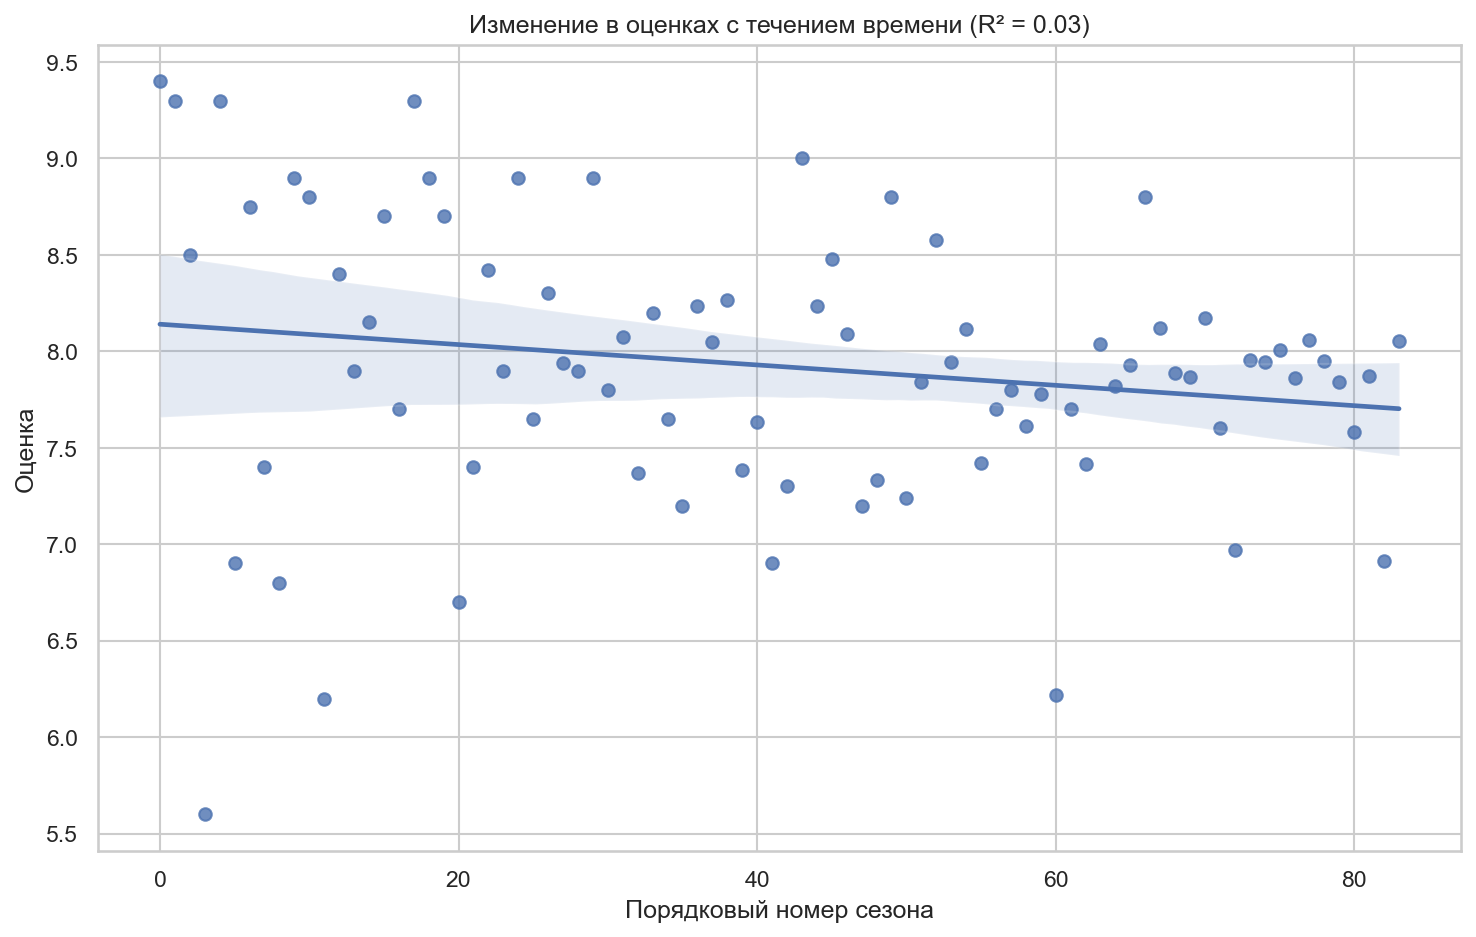

In [161]:
plt.figure(figsize=(10, 6), dpi=150)
sns.set(style="whitegrid")

r_square = np.corrcoef(season_df.rating.to_numpy(), season_df.index.to_numpy())[0][1] ** 2

sns.regplot(x=np.arange(season_df.shape[0]), y='rating', data=season_df)
plt.tight_layout()
plt.title(f'Изменение в оценках с течением времени (R² = {(r_square).round(2)})')
plt.ylabel('Оценка')
plt.xlabel('Порядковый номер сезона');

В среднем с течением времени оценки **аниме ухудшились**, хоть и не сильно. На это могли повлиять очень много факторов (синдром утенка, поставка сериалов "на конвеер" и так далее), так что не берусь выявлять причинно-следственную связь.

Но все же отмечу, что старых аниме довольно мало, из-за чего при агрегации старых, но хороших, произведений среднее не "портилось" низкооцененными сосезонниками, поэтому к данному графику я бы относился довольно скептически.

## Модуль 5: Исследование категорий

### Начнем с простых категорий: студии. Сгруппируем оценки по студиям, построим графики и попроверяем гипотезы.

Сформулируем гипотезу о том, что оценки не зависят от студии. То есть:

H0: μ₁ = ... = μₙ

H1: μ₁ ≠ ... ≠ μₙ (хотя бы 1)

In [44]:
studio_df = df[['studio', 'rating']]
studio_df = studio_df.dropna().groupby('studio').agg('mean')
studio_df.sort_values(by='rating', inplace=True, ascending=False)
studio_df.head()

,rating
studio,
Wit Studio,9.111111
Studio VOLN,9.100000
M2,9.000000
G.CMay Animation & Film,9.000000
Nippon Animation,8.800000


Посмотрим на средние оценки в самой низко оцененной и самой высоко оцененной студии.

In [45]:
print(f'Самая высоко оцененная студия: {studio_df.iloc[0].name}, рейтинг: {studio_df.iloc[0].rating}')
print(f'Самая высоко оцененная студия: {studio_df.iloc[-1].name}, рейтинг: {studio_df.iloc[-1].rating}')

Самая высоко оцененная студия: Wit Studio, рейтинг: 9.11111111111111
Самая высоко оцененная студия: Marvy Jack, рейтинг: 3.9


Пока результат говорит о том, что итоговая средняя оценка очень сильно зависит от студии. Чтобы не строить догадок проверим результат при помощи

**множественных t-тестов с учетом поправки Бонферрони**

Такой тест придирчив к количеству наблюдений и распределению. Ограничем студии по количеству наблюдений, попавших в выборку. Чтобы как-то исправить проблему с нормальностью распределения понизим критический уровень значимости до `0.01`.

In [61]:
studio_df = df[['studio', 'rating']]
studio_df.head()

enough_count = studio_df.dropna().groupby('studio').agg('count')
enough_count = enough_count[enough_count['rating'] >= 10].index.to_list()

studio_df = studio_df[studio_df['studio'].isin(enough_count)]

studios = studio_df['studio'].unique()

num_comparisons = len(studios) * (len(studios) - 1) // 2

alpha = 0.01
corrected_alpha = alpha / num_comparisons

p_values = []

for i, class1 in enumerate(studios):
    for j, class2 in enumerate(studios):
        if i < j:
            t_stat, p_val = stats.ttest_ind(
                studio_df[studio_df['studio'] == class1]['rating'],
                studio_df[studio_df['studio'] == class2]['rating']
            )
            p_values.append(p_val)

            if p_val < corrected_alpha:
                print(f"Найдено статистически значимое различие между студиями {class1} и {class2} (p-value = {p_val})")
                break
    else:
        continue
    break

Найдено статистически значимое различие между студиями Madhouse Studios и Toei Animation (p-value = 2.546879228788579e-06)


Как мы и предполагали, **качество произведения зависит от студии создателя**.

Составим топ-30 аниме студий.

In [192]:
studio_df = df[['studio', 'rating']]
studio_df.head()

groupes_studio_df = studio_df.dropna().groupby('studio').agg('mean')
groupes_studio_df.sort_values(by='rating', inplace=True, ascending=False)
groupes_studio_df = groupes_studio_df.head(30).index

result_mask = studio_df['studio'].isin(groupes_studio_df.to_list())

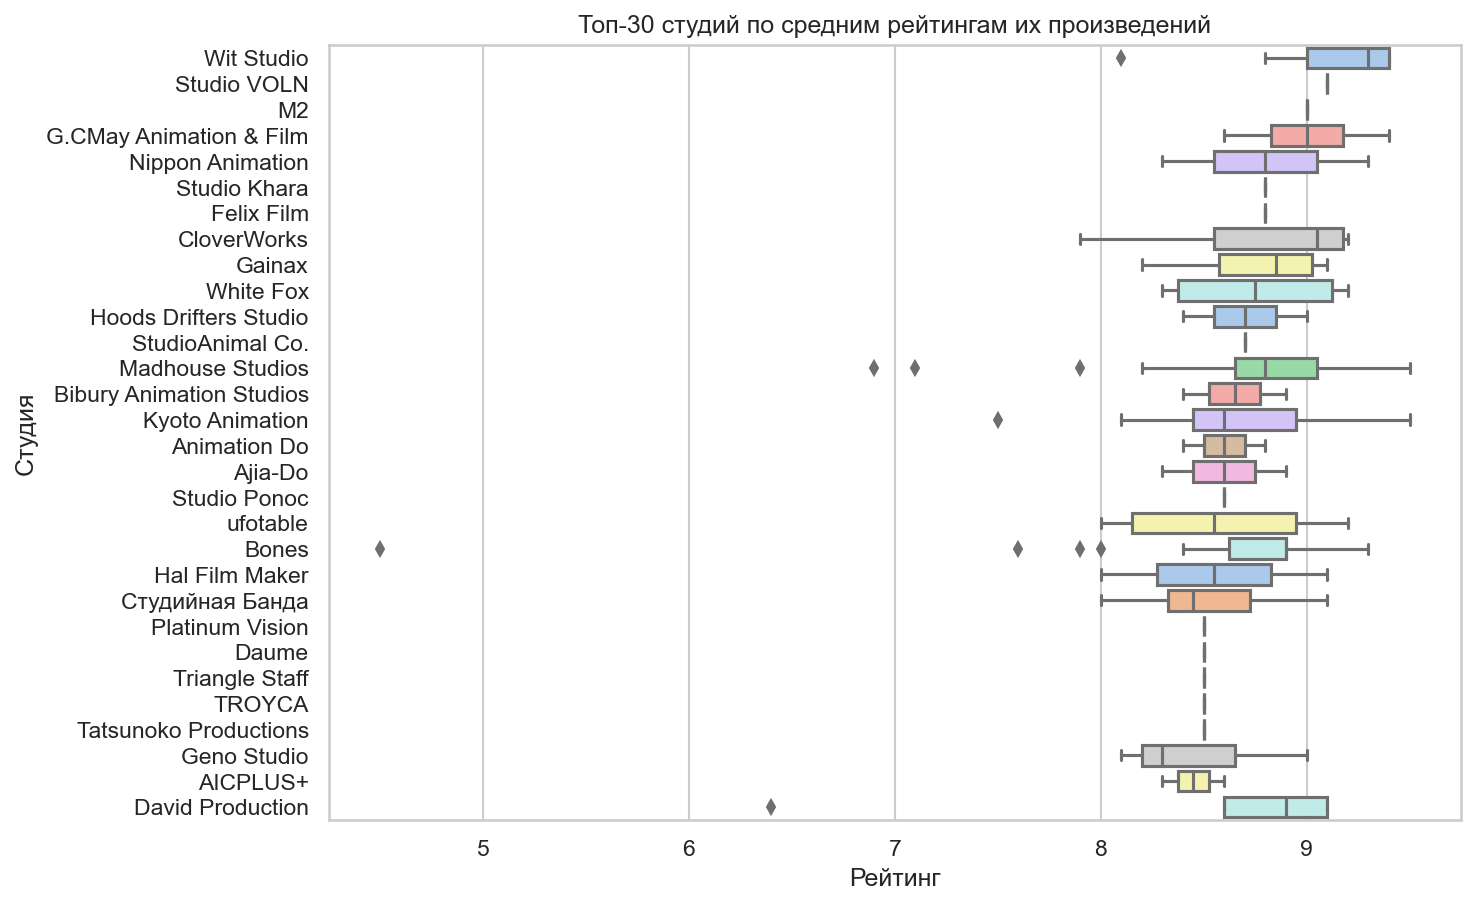

In [193]:
plt.figure(figsize=(10, 6), dpi=150)
sns.set(style="whitegrid")

sns.boxplot(x=studio_df[result_mask]['rating'],
            y=studio_df[result_mask]['studio'],
            order=groupes_studio_df,
           palette='pastel')

plt.tight_layout()
plt.xlabel('Рейтинг')
plt.ylabel('Студия')
plt.title('Топ-30 студий по средним рейтингам их произведений');

Половина групп, попавших в топ-30 имеют в себе всего 1 значение, что не очень информативно. Будем включать в топ-30 студии, у которых в выборку попали хотя бы 5 наблюденя.

In [172]:
studio_df = df[['studio', 'rating']]
studio_df.head()

enough_count = studio_df.dropna().groupby('studio').agg('count')
enough_count = enough_count[enough_count['rating'] >= 5].index.to_list()

studio_df = studio_df[studio_df['studio'].isin(enough_count)]

groupes_studio_df = studio_df.dropna().groupby('studio').agg('median')
groupes_studio_df.sort_values(by='rating', inplace=True, ascending=False)
groupes_studio_df = groupes_studio_df.head(30).index

result_mask = (studio_df['studio'].isin(groupes_studio_df.to_list()))

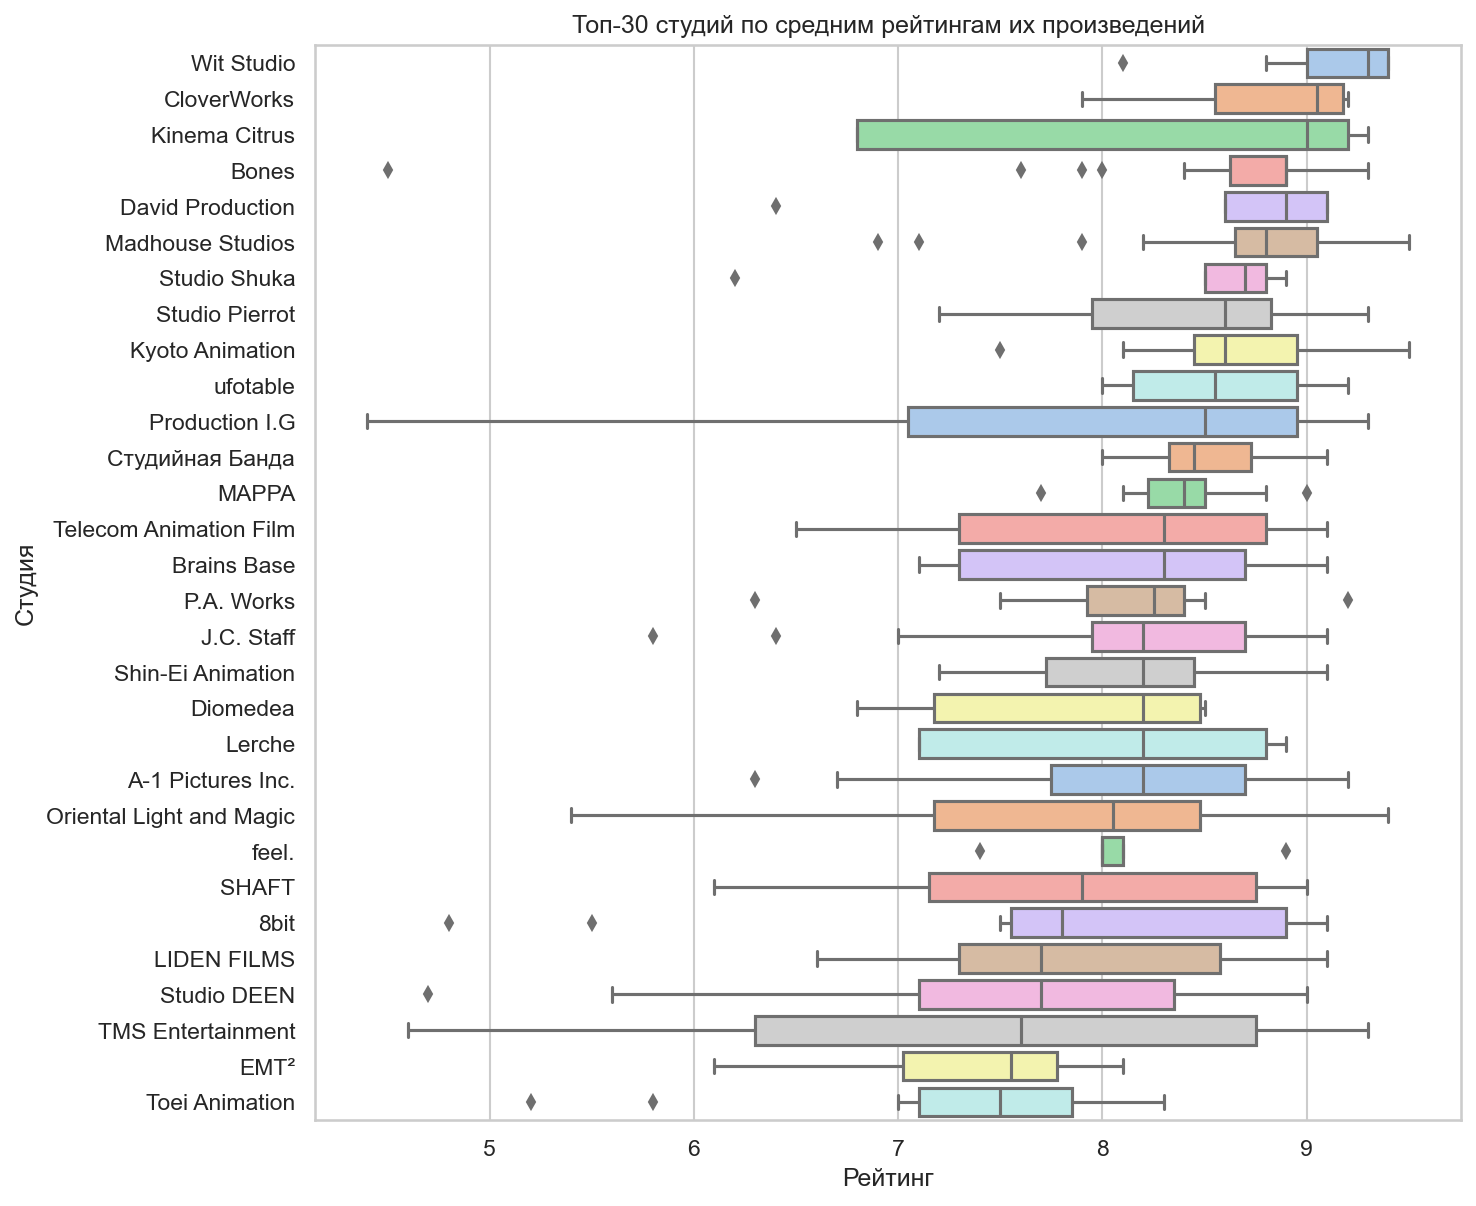

In [173]:
plt.figure(figsize=(10, 8), dpi=150)
sns.set(style="whitegrid")

sns.boxplot(x=studio_df[result_mask]['rating'],
            y=studio_df[result_mask]['studio'],
           order=groupes_studio_df,
           palette='pastel')
plt.tight_layout()
plt.ylabel('Студия')
plt.xlabel('Рейтинг')
plt.title('Топ-30 студий по средним рейтингам их произведений');

Итого мы имеем список надежных студий анимации, чьи произведения в среднем будут отличаться качеством и придутся всем по вкусу.

### Анализ жанров
Для начала понадобится разбить колонку с жанрами.

In [76]:
df.head()

,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
0,Другая сторона сэйю на радио,Драма;Комедия;Школа,7.7,178.0,Весна 2024,Connect,ТВ Сериал,16+,ТВ Сериал,12
1,Истории подделок,Детектив;Комедия;Сверхъестественное;Этти,8.7,1593.0,Зима 2012,SHAFT,ТВ Сериал,18+,ТВ Сериал,11
2,Дневник будущего: Повторный набор,Психологическое;Сверхъестественное;Сёнэн;Экшен,8.1,3135.0,None,asread,OVA,18+,OVA,1
3,Рассвет Йоны,Комедия;Приключения;Романтика;Сёдзё;Фэнтези;Экшен,8.9,2891.0,Осень 2014,Studio Pierrot,ТВ Сериал,16+,ТВ Сериал,24
4,"Дальше, чем космос",Драма;Комедия;Повседневность;Приключения,8.7,459.0,Зима 2018,Madhouse Studios,ТВ Сериал,16+,ТВ Сериал,13


In [145]:
genres_df = pd.DataFrame([])

def genres_separate(series):
    global genres_df
    genres_dict = {}
    genres_dict['genres'] = series['genres'].split(';')
    genres_dict['title'] = series['title']
    genres_dict['rating'] = series['rating']
    if genres_df.empty:
        genres_df = pd.DataFrame(genres_dict)
    else:
        genres_df = pd.concat([genres_df, pd.DataFrame(genres_dict)])
df[['title', 'genres', 'rating']].apply(genres_separate, axis=1)
genres_df = genres_df.dropna()
genres_df

,genres,title,rating
0,Драма,Другая сторона сэйю на радио,7.7
1,Комедия,Другая сторона сэйю на радио,7.7
2,Школа,Другая сторона сэйю на радио,7.7
0,Детектив,Истории подделок,8.7
1,Комедия,Истории подделок,8.7
...,...,...,...
0,Гарем,Повелитель тьмы: Другая история мира 2,8.1
1,Комедия,Повелитель тьмы: Другая история мира 2,8.1
2,Магия,Повелитель тьмы: Другая история мира 2,8.1
3,Фэнтези,Повелитель тьмы: Другая история мира 2,8.1


Убедимся в том, что все отработало без ошибок, оценив среднее.

In [99]:
genres_df[['title', 'rating']].drop_duplicates()['rating'].mean()

7.846926536731633

Оценки совпали, значит ошибок нет. Проверим гипотезу о равномерности распределения жанров с помощью **Критерия Хи-квадрат Пирсона**.

Гипотезы:

H0: *X₁, ..., Xₙ ~ iid U[a, b]*

H0: *X₁, ..., Xₙ ͊!~ iid U[a, b]*

In [121]:
genres_counts = genres_df['genres'].value_counts()
n = genres_df.shape[0]
n_genres = len(genres_counts)
expect = n / n_genres

chi2, p_value = stats.chisquare(genres_counts, f_exp=[expect] * n_genres)
print(f'p_value = {p_value.round(5)}')

p_value = 0.0


Имеем статистически значимый результат, что жанры не одинаково популярны. Построим для них визуализацию.

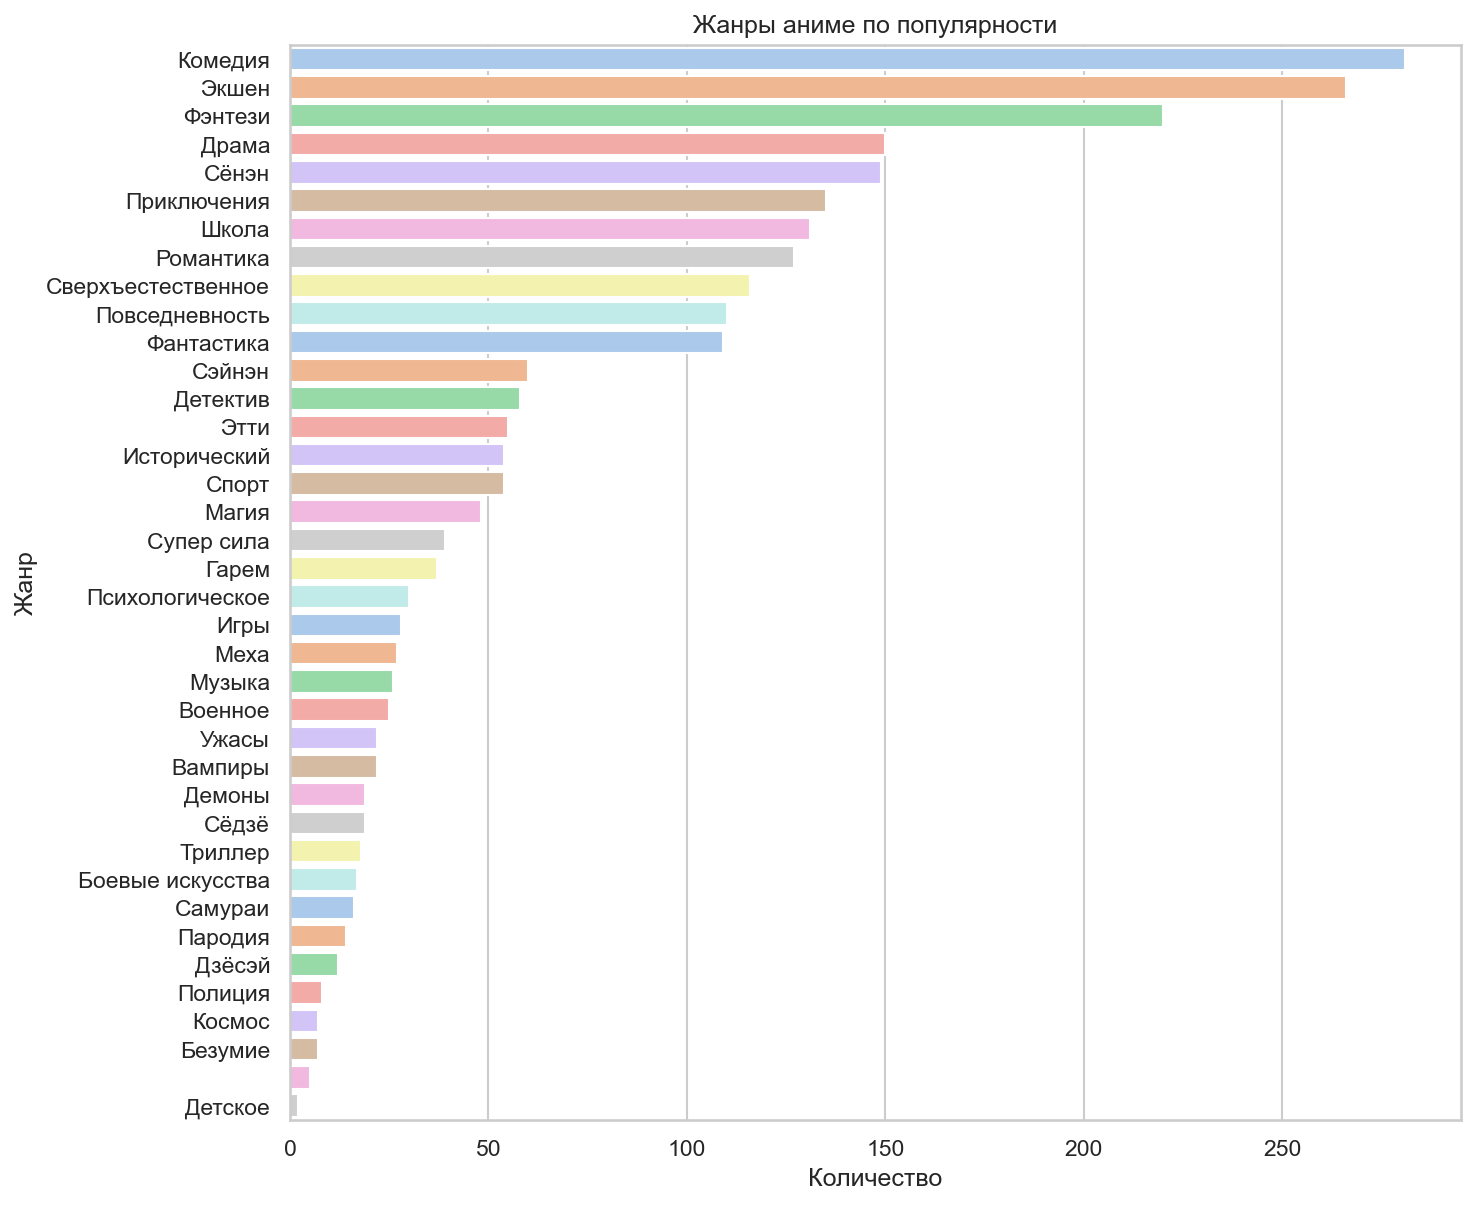

In [167]:
plt.figure(figsize=(10, 8), dpi=150)
sns.set(style="whitegrid")

sns.barplot(y=genres_counts.index, x=genres_counts, palette='pastel')
plt.tight_layout()
plt.ylabel('Жанр')
plt.xlabel('Количество')
plt.title('Жанры аниме по популярности');

Теперь сравним средние оценки каждого жанра. Гипотезы:

H0: μ₁ = ... = μₙ

H1: μ₁ ≠ ... ≠ μₙ (хотя бы 1)

In [140]:
model = ols('rating ~ C(genres)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(genres),693.053990,469.0,1.798502,0.000001
Residual,166.793571,203.0,NaN,NaN


Как видим нулевая **гипотеза отвергается**, качество зависит от жанра. Построим распределение средних оценок по жанру.

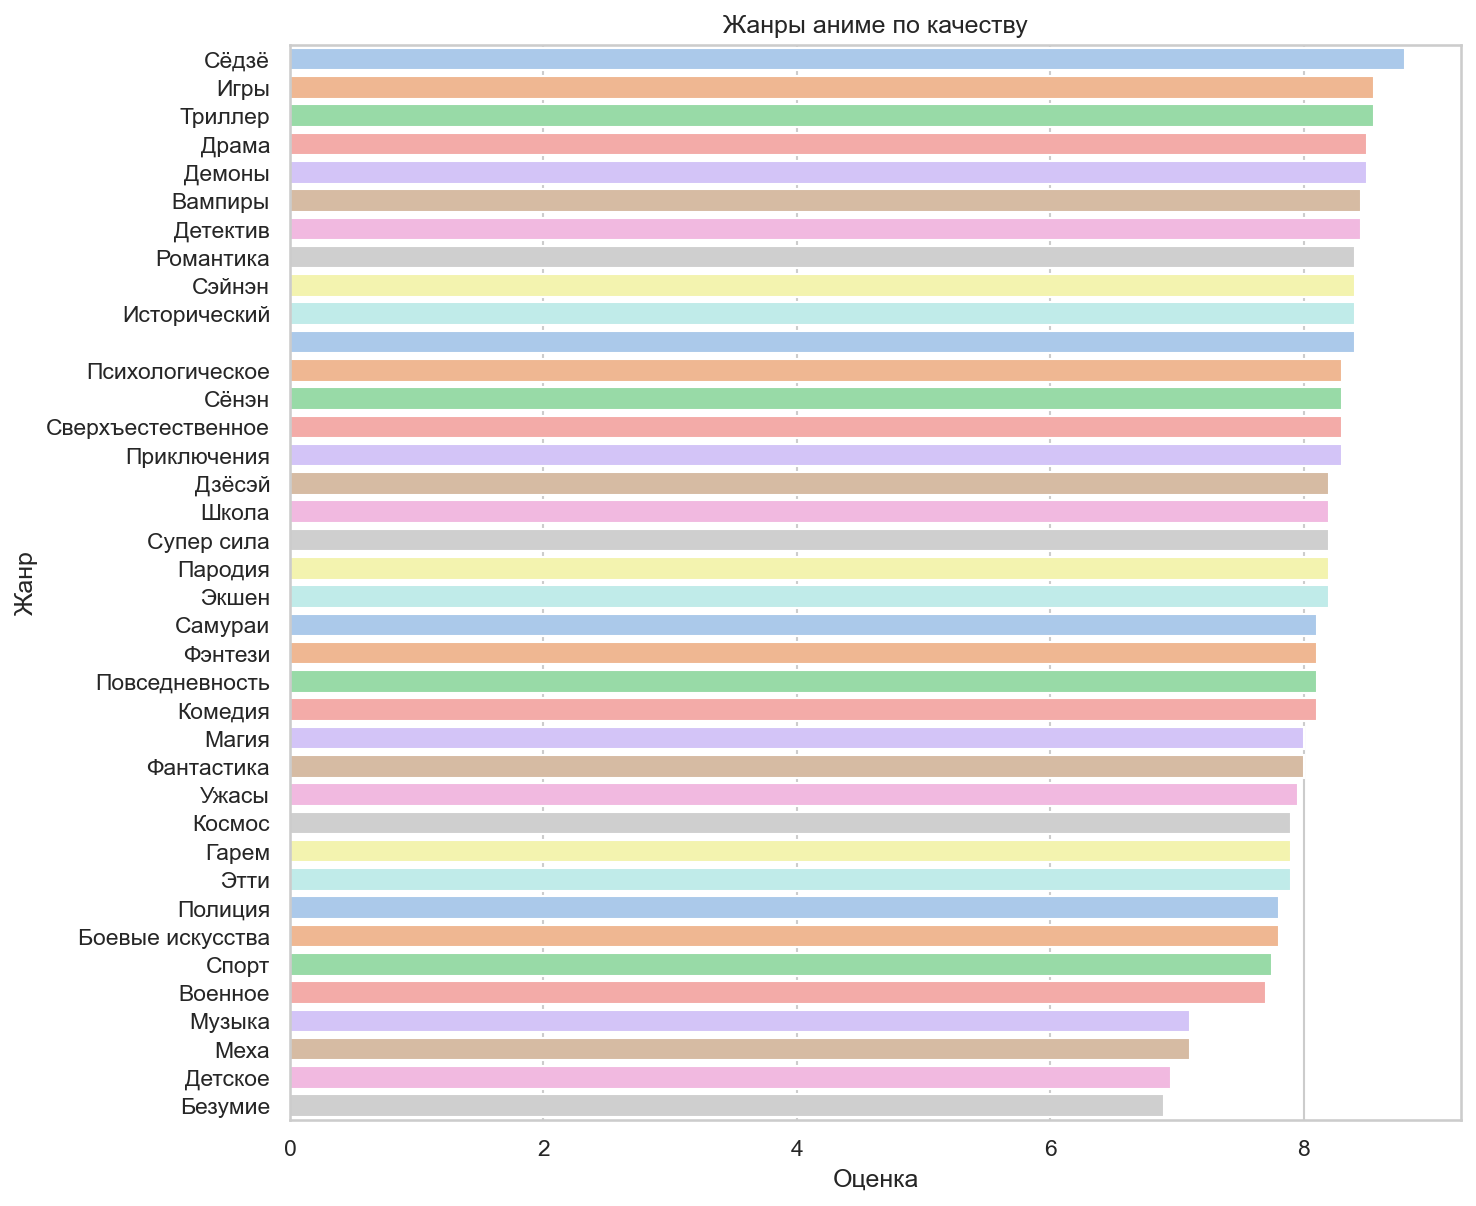

In [170]:
gr_genres = genres_df
gr_genres = gr_genres[['rating', 'genres']].groupby('genres').agg('median').sort_values('rating', ascending=False)

plt.figure(figsize=(10, 8), dpi=150)
sns.set(style="whitegrid")

sns.barplot(y=gr_genres.index, x=gr_genres.rating, palette='pastel')
plt.tight_layout()
plt.ylabel('Жанр')
plt.xlabel('Оценка')
plt.title('Жанры аниме по качеству');

Забавное замечание, что аниме без жанров вовсе лучше, нежели некоторые жанры :)

### Также проведем анализ зависимости рейтинга от количества серий.

Сравним средние оценки каждого жанра. Гипотезы:

H0: μ₁ = ... = μₙ

H1: μ₁ ≠ ... ≠ μₙ (хотя бы 1)

In [186]:
model = ols('rating ~ C(type)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(type),7.982258,4.0,1.5671,0.181355
Residual,842.998941,662.0,NaN,NaN


Мы не получили значимого различия, значит **не отвергаем нуливую гипотезу**, все типы хороши.

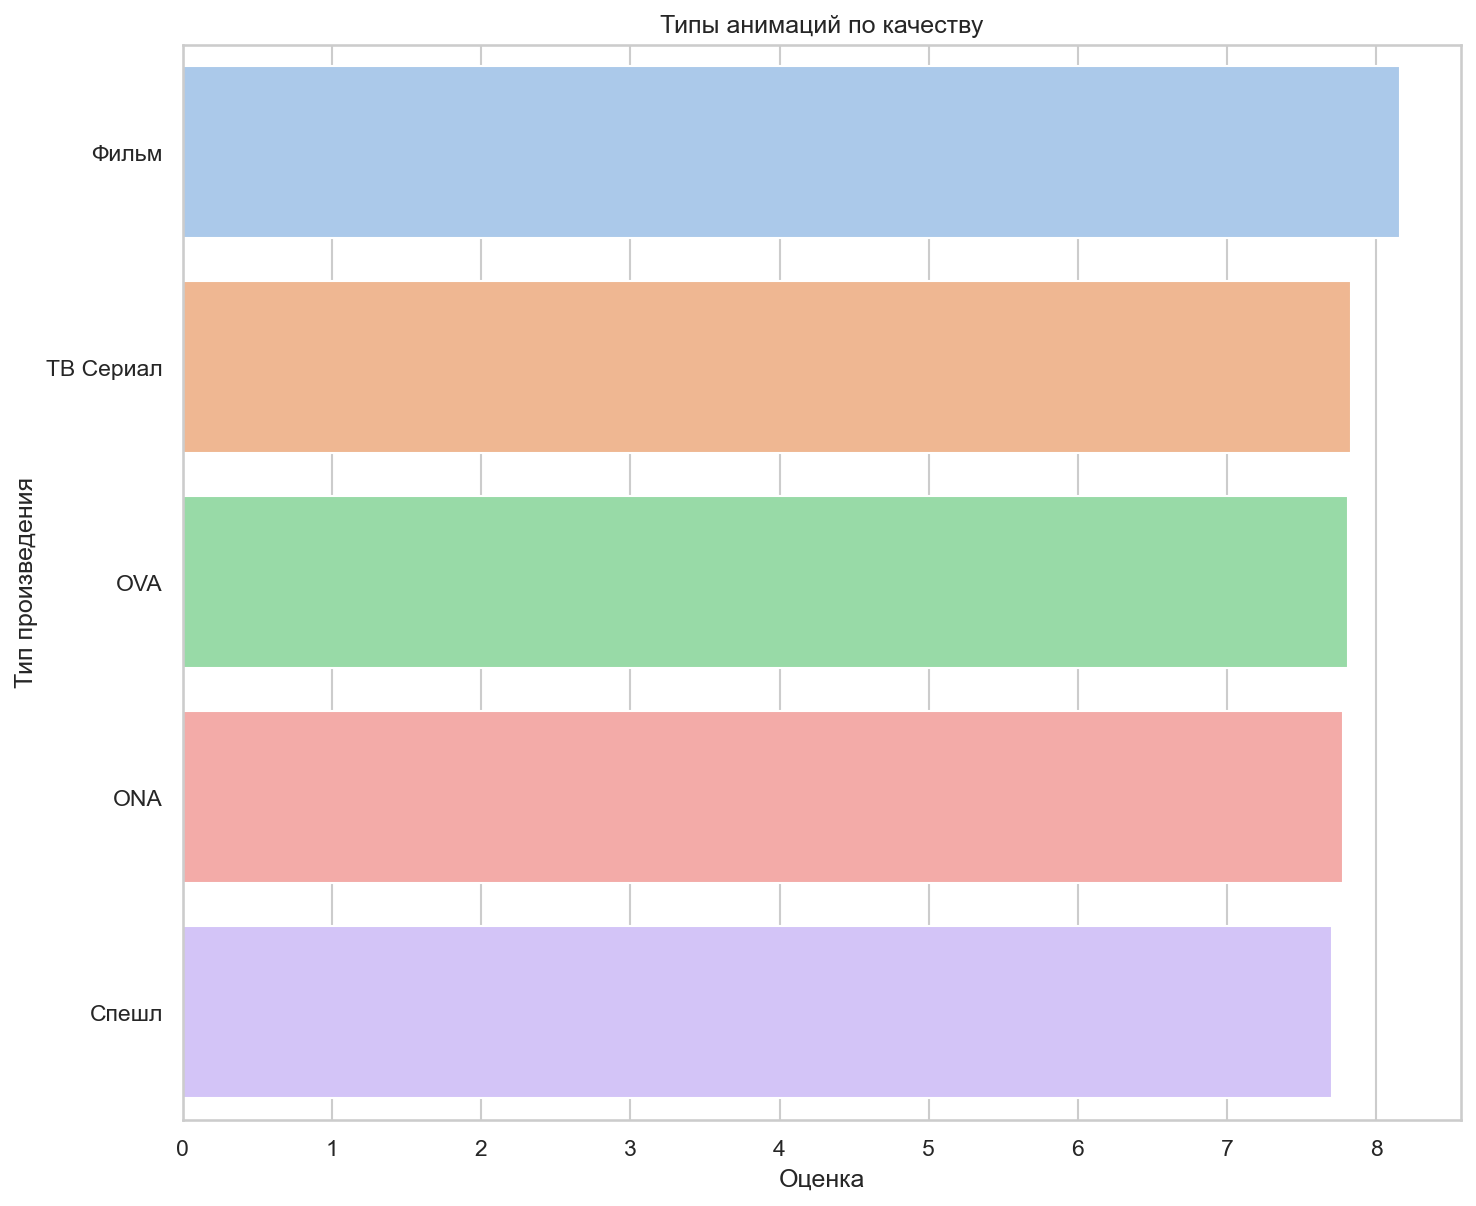

In [191]:
type_df = df[['type', 'rating']]
gr_type = count_df
gr_type = gr_type[['rating', 'type']].groupby('type').agg('mean').sort_values('rating', ascending=False)

plt.figure(figsize=(10, 8), dpi=150)
sns.set(style="whitegrid")

sns.barplot(y=gr_type.index, x=gr_type.rating, palette='pastel')
plt.tight_layout()
plt.ylabel('Тип произведения')
plt.xlabel('Оценка')
plt.title('Типы анимаций по качеству');

Получается, что при выборе аниме не стоит обращать внимание на тип произведения, потому что по большей части их качество не различается.

## Ну и наконец попробуем найти лучших представителей, с которых будет не стыдно начать знакомство с культурой японской анимации.